In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline
plt.style.use('seaborn')

In [2]:
df_raw = pd.read_csv('data/tx_ev_registrations_public.csv')
df_raw = df_raw[(df_raw.Technology == 'BEV')]
df_raw.head()

,Vehicle ID,ZIP Code,Registration Valid Date,VIN Prefix,DMV_ID,DMV ID Complete,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name,Technology
0,TX-003-0344972,75060,2021-07-01 00:00:00.000,5YJ3E1EA,3,TX3,TX Registration Data from DFW Clean Cities (20...,NaN,TX,ZIP Code,Tesla Model 3,BEV
1,TX-003-0344978,77005,2021-07-01 00:00:00.000,5YJ3E1EA,3,TX3,TX Registration Data from DFW Clean Cities (20...,NaN,TX,ZIP Code,Tesla Model 3,BEV
2,TX-003-0345022,75039,2021-07-01 00:00:00.000,5YJ3E1EA,3,TX3,TX Registration Data from DFW Clean Cities (20...,NaN,TX,ZIP Code,Tesla Model 3,BEV
3,TX-003-0345034,77006,2021-07-01 00:00:00.000,5YJ3E1EA,3,TX3,TX Registration Data from DFW Clean Cities (20...,NaN,TX,ZIP Code,Tesla Model 3,BEV
4,TX-003-0345040,77094,2021-07-01 00:00:00.000,5YJ3E1EA,3,TX3,TX Registration Data from DFW Clean Cities (20...,NaN,TX,ZIP Code,Tesla Model 3,BEV


In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2019-11-01,131.0
2019-11-02,2.0
2019-11-03,3.0
2019-11-04,13.0
2019-11-05,13.0
...,...
2022-06-28,235.0
2022-06-29,242.0
2022-06-30,203.0


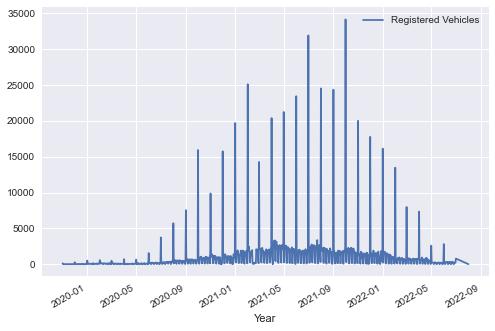

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

In [6]:
# result = seasonal_decompose(df, model='multiplicative')
# fig = result.plot()

In [7]:
df['Registered Vehicles'].mean()

1095.7661122661123

## **RESAMPLING

In [ ]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [ ]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

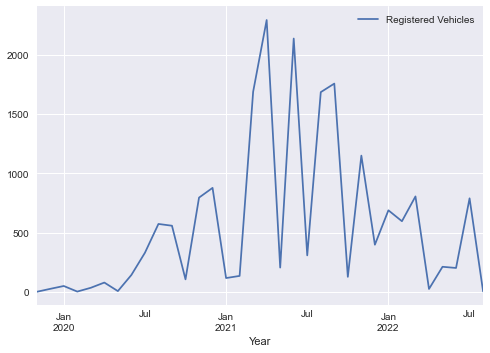

In [8]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## First Model (before train/test split)

In [9]:
auto_model = pm.auto_arima(df, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=557.295, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=548.705, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=553.682, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=542.071, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=539.034, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=540.306, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=539.835, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=538.705, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=539.343, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=538.253, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=536.993, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=550.241, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=538.273, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=549.432, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, 

## Testing 

In [10]:
adtest = adfuller(df)
display(adtest)

(-4.791872619697481,
 5.6366718854849814e-05,
 0,
 33,
 {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216},
 370.2283021622996)

## Modeling

In [11]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2017-06-30':'2021-12-31']
test = df['2022-01-31':]
combined = df

train

,Registered Vehicles
Year,
2019-11-30,2.0
2019-12-31,27.0
2020-01-31,51.0
2020-02-29,4.0
2020-03-31,36.0
2020-04-30,80.0
2020-05-31,8.0
2020-06-30,144.0
2020-07-31,331.0


In [12]:
naive = train.shift(1)
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

932.7227883996402

In [13]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=431.192, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=425.521, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=428.951, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=421.282, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=418.867, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=420.702, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=420.340, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=419.079, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=422.340, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=419.077, Time=0.09 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.586 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -2

### The best model is :  ARIMA (3,0,0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0739      0.172      0.430      0.667      -0.263       0.411
ar.L2          0.3729      0.188      1.984      0.047       0.004       0.741
ar.L3          0.4317      0.191      2.264      0.024       0.058       0.805
sigma2      4.586e+05   1.41e+05      3.261      0.001    1.83e+05    7.34e+05


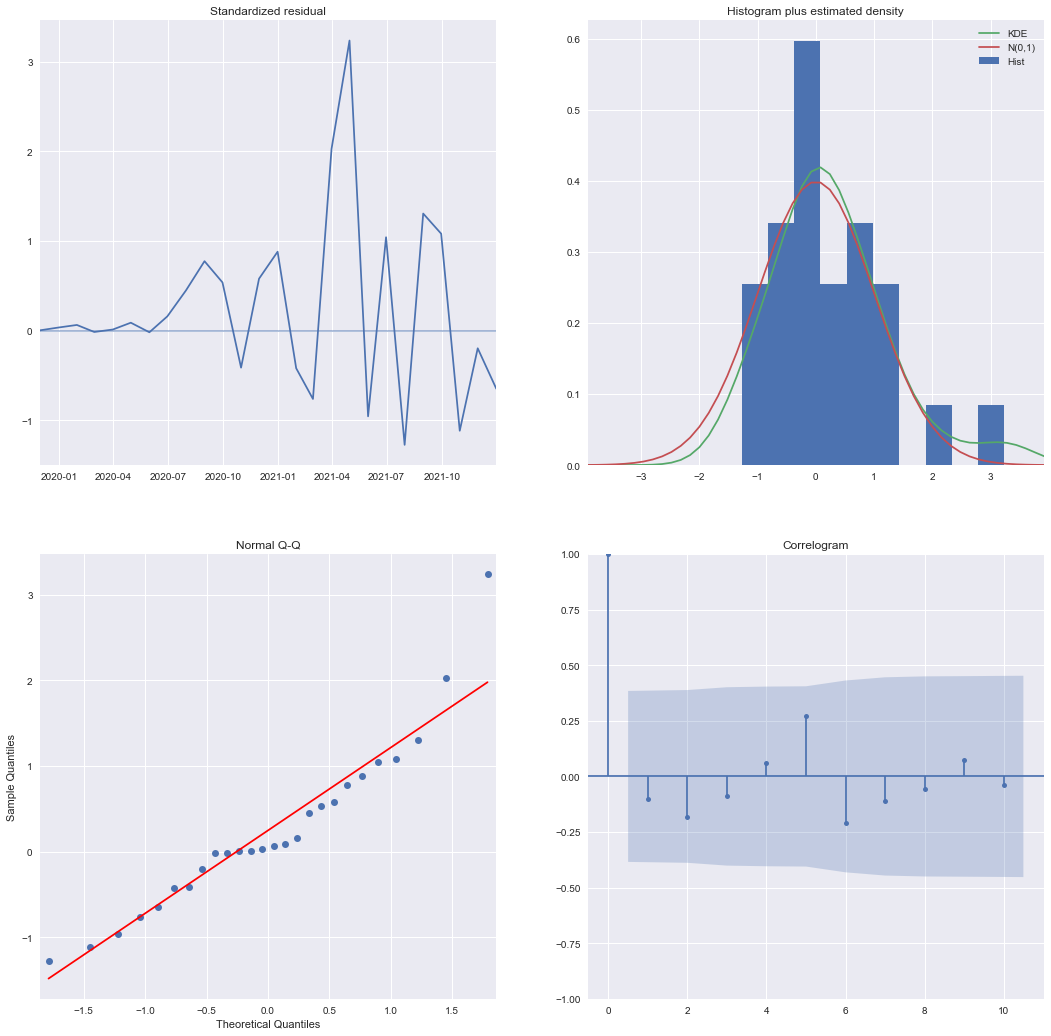

In [14]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(3,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [15]:
pred = output.get_prediction(start=pd.to_datetime('2020-12-31'), end=pd.to_datetime('2022-08-31'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2020-12-31,-987.241632,1667.267914
2021-01-31,-919.344148,1735.165397
2021-02-28,-647.495714,2007.013832
2021-03-31,-894.199368,1760.310177
2021-04-30,-1100.889371,1553.620175
2021-05-31,-469.627955,2184.881591
2021-06-30,271.752395,2926.261941
2021-07-31,-102.741392,2551.768154
2021-08-31,-418.542489,2235.967057
2021-09-30,-165.062728,2489.446818


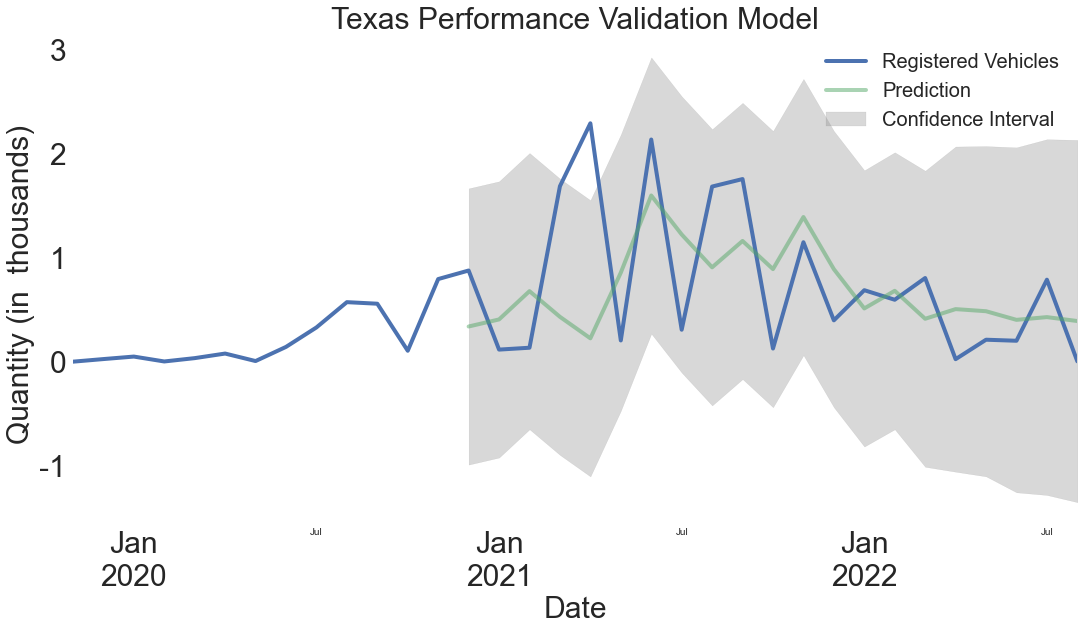

In [16]:

sns.set_style(style='white')
rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in  thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Texas Performance Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [17]:
# Beginning our forecasting for next 3 years (36 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(3,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0739      0.172      0.430      0.667      -0.263       0.411
ar.L2          0.3729      0.188      1.984      0.047       0.004       0.741
ar.L3          0.4317      0.191      2.264      0.024       0.058       0.805
sigma2      4.586e+05   1.41e+05      3.261      0.001    1.83e+05    7.34e+05


In [18]:
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int(alpha=.3)
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2022-09-30,-249.859442,1020.678530,385.409544
2022-10-31,-295.550020,978.856261,341.653121
2022-11-30,-506.649006,861.971262,177.661128
2022-12-31,-445.278905,1039.335852,297.028474
2023-01-31,-529.302854,980.887829,225.792487
2023-02-28,-584.328768,988.550132,202.110682
2023-03-31,-588.041862,1027.043356,219.500747
2023-04-30,-638.228434,1005.794039,183.782803
2023-05-31,-660.779680,1017.651516,178.435918
2023-06-30,-680.533977,1022.580873,171.023448


In [19]:
future_prediction['prediction'].sum()

4416.040296133303

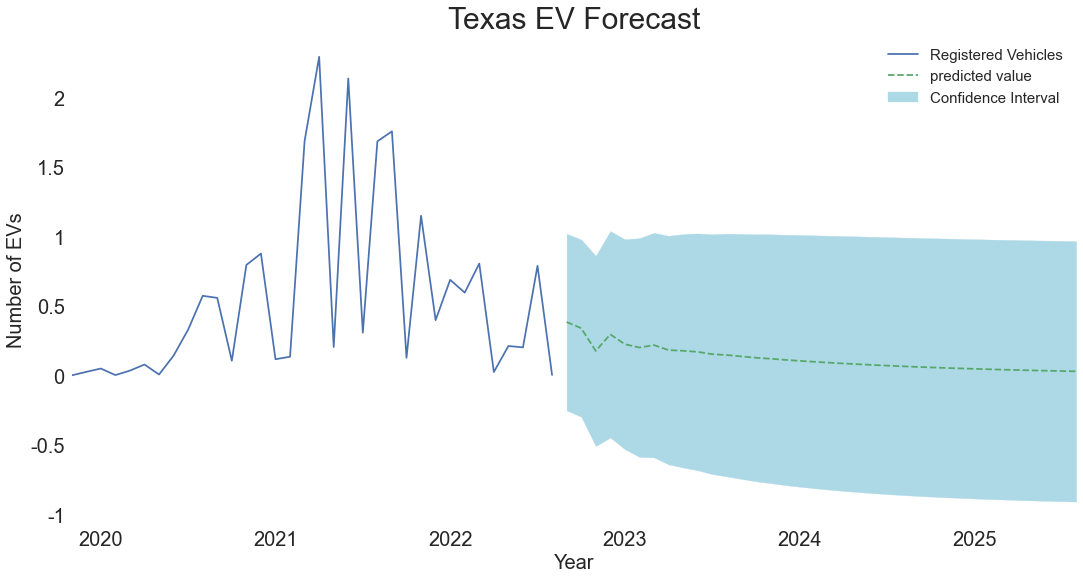

In [20]:
sns.set_style(style='white')
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Actual')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'], color = 'lightblue',
                label='Confidence Interval')


ax.set_xlabel('Year',fontsize=20)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of EVs',fontsize=20)
plt.yticks(fontsize=20)

# scale_y = 1e5
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Texas EV Forecast',fontsize=30)
plt.legend(fontsize = 15)
plt.show()